This file is created to illustrate the effect of depolarizing error on the cosine filter methdo in therms of real time evolution. First we do it numerically without quantum circuit and trotterization but just scipy.linalg.expm. Secondly, we implement it by qunatum circuit with Trotter_product.

# Basic set up

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from pennylane_qiskit import load_pauli_op
from qiskit.quantum_info import Operator, SparsePauliOp

In [4]:
# ---------------------------------------------------------
# Build Hamiltonian (same as your get_hamiltonian)
# ---------------------------------------------------------
def get_hamiltonian_pl(nq, J):
    coeffs = []
    ops = []
    for i in range(nq - 1):
        coeffs.append(J)
        ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
    coeffs.append(J)
    ops.append(qml.PauliZ(nq - 1) @ qml.PauliZ(0))
    for i in range(nq):
        coeffs.append(J)
        ops.append(qml.PauliX(i))
    return qml.Hamiltonian(coeffs, ops)

nqubits = 4
dev = qml.device("default.qubit", wires=nqubits+1)
state = 1/np.sqrt(2**4) * np.ones(2**4)
H = get_hamiltonian_pl(4,1)
H_array = qml.matrix(H)
eval, _ = np.linalg.eigh(H_array)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_array))
H_cos = load_pauli_op(SparsePauliOp(["Y"])^H)


# Numerical calculation

In [15]:
def postselect_rho(density_matrix, postselect_qubit, postselect_value):
    nq = int(np.log2(density_matrix.shape[0]))
    assert postselect_qubit < nq

    indices = np.arange(1 << nq)
    mask = (indices & (1 << postselect_qubit)).astype(bool)
    if not postselect_value:
        mask = np.logical_not(mask)
    indices = indices[mask]

    return density_matrix[np.ix_(indices, indices)]



def cosine_filtering(initial_state, scaled_hamiltonian, dt, nreps):
    Y = np.array([[0, -1j], [1j, 0]])
    U = sc.linalg.expm(-1j * np.kron(Y, scaled_hamiltonian) * dt)
    eigvals, eigvecs = np.linalg.eigh(scaled_hamiltonian)
    gs = eigvecs[:, np.argmin(eigvals)]
    gs_d = qml.math.dm_from_state_vector(gs)

    nstates = initial_state.shape[0]
    nq = int(np.log2(nstates))

    rho = initial_state
    fidelity = qml.math.fidelity(gs_d, rho)

    # ---------- Step #0: expectation of initial state ----------
    exp0 = np.einsum("ij,ji->", rho, scaled_hamiltonian)
    print(f"Step #0: {exp0} {fidelity}")

    # ---------- steps #1 ... ----------
    for i in range(1, nreps+1):
        # Embed system rho into ancilla⊗system rho_1
        rho_1 = np.pad(rho, (0, nstates))

        # Apply U
        Urho_1 = U @ rho_1 @ U.conj().T

        # Postselect ancilla = 0
        new_rho = postselect_rho(Urho_1, nq, 0)
        new_rho /= np.trace(new_rho)

        # Compute expectation
        exp = np.einsum("ij,ji->", new_rho, scaled_hamiltonian)

        ## compute fidelity of two density matrix

        fidelity = qml.math.fidelity(gs_d, new_rho)

        # update rho
        rho = new_rho

        print(f"Step #{i}: {exp} {fidelity}")


#temp_init = np.ones(2**4)/ np.sqrt(2**4)
temp_init = np.zeros(2**4)
temp_init[0] = 1
initial_state = np.outer(temp_init, temp_init)

initial_state /= np.trace(initial_state)
print('###### Without error #######')
cosine_filtering(initial_state, H_array, np.pi/2, 10)

###### Without error #######
Step #0: (0.88268343236509+0j) 0.005873803467891937
Step #1: (0.4787227741813043+0j) 0.06325328509755454
Step #2: (0.381619133814427+0j) 0.12093703823716352
Step #3: (0.32512892516002156+0j) 0.18621227886640995
Step #4: (0.28337114575538785+0j) 0.2597893500544091
Step #5: (0.24507685301572715+0j) 0.3416932278687972
Step #6: (0.20759058195588928+0j) 0.4288743260106588
Step #7: (0.17179273490387437+0j) 0.5162512621588906
Step #8: (0.13927280578389623+0j) 0.5986738284786769
Step #9: (0.11115234147493079+0j) 0.6724028043449707
Step #10: (0.08779634151680563+0j) 0.7356259696765741


In [3]:
2.4*9/(2*np.pi)

3.437746770784939

In [178]:
## with depolarizing error
def postselect_rho(density_matrix, postselect_qubit, postselect_value):
    nq = int(np.log2(density_matrix.shape[0]))
    assert postselect_qubit < nq

    indices = np.arange(1 << nq)
    mask = (indices & (1 << postselect_qubit)).astype(bool)
    if not postselect_value:
        mask = np.logical_not(mask)
    indices = indices[mask]

    return density_matrix[np.ix_(indices, indices)]


def cosine_filtering(initial_state, scaled_hamiltonian, dt, nreps):
    Y = np.array([[0, -1j], [1j, 0]])
    U = sc.linalg.expm(-1j * np.kron(Y, scaled_hamiltonian) * dt)

    nstates = initial_state.shape[0]
    nq = int(np.log2(nstates))

    rho = initial_state
    exp0 = np.einsum("ij,ji->", rho, scaled_hamiltonian)
    print(f"Step #0: {exp0}")
    for i in range(1, nreps+1):
        rho_1 = np.pad(rho, (0, nstates))
        Urho_1 = U @ rho_1 @ U.conj().T
        new_rho = postselect_rho(Urho_1, nq, 0)
        new_rho /= np.trace(new_rho)
        ## add depolarizing error
        error_rate = 1e-2
        new_rho = (1-error_rate)* new_rho + error_rate * np.trace(new_rho)* np.eye(2**nqubits) / 2**nqubits
        exp = np.einsum("ij,ji->", new_rho, scaled_hamiltonian)
        rho = new_rho
        print(f"Step #{i}: {exp}")

#temp_init = np.ones(2**4)/ np.sqrt(2**4)
temp_init = np.zeros(2**4)
temp_init[0] = 1
initial_state = np.outer(temp_init, temp_init)

initial_state /= np.trace(initial_state)
print('###### With depolarizing error #######')
cosine_filtering(initial_state, H_array, np.pi/2, 10)

###### With depolarizing error #######
Step #0: (0.88268343236509+0j)
Step #1: (0.47893554643949116+0j)
Step #2: (0.3823614796796981+0j)
Step #3: (0.32631389906768965+0j)
Step #4: (0.284912077861034+0j)
Step #5: (0.24711012980204994+0j)
Step #6: (0.2103667202339197+0j)
Step #7: (0.17553538681883216+0j)
Step #8: (0.14409464971012517+0j)
Step #9: (0.11704008494041866+0j)
Step #10: (0.09464387982658191+0j)


In [179]:
def cosine(initial_state, scaled_hamiltonian, dt, nreps):
    U = sc.linalg.cosm(scaled_hamiltonian * dt)

    nstates = initial_state.shape[0]
    nq = int(np.log2(nstates))

    rho = initial_state
    exp0 = np.einsum("ij,ji->", rho, scaled_hamiltonian)
    print(f"Step #0: {exp0}")
    for i in range(1, nreps+1):
        Urho_1 = U @ rho @ U.conj().T
        new_rho = Urho_1
        new_rho /= np.trace(new_rho)
        error_rate = 1e-2
        new_rho = (1-error_rate)* new_rho + error_rate * np.trace(new_rho)* np.eye(2**nqubits) / 2**nqubits
        exp = np.einsum("ij,ji->", new_rho, scaled_hamiltonian)
        rho = new_rho
        print(f"Step #{i}: {exp}")

# initial_state = 0
# # initial_state option 1
# temp = sc.linalg.hadamard(1 << nqubits, dtype=np.float64)
# for i in range(1 << nqubits):
#     state = temp[:, i]
#     initial_state += np.outer(state, state)
#
#     # initial_state option 2
#     # for i in range(1 << nq):
#     #     state = np.random.random(1 << nq)
#     #     initial_state += np.outer(state, state)
#
# initial_state /= np.trace(initial_state)

#temp_init = np.ones(2**4)/ np.sqrt(2**4)
temp_init = np.zeros(2**4)
temp_init[0] = 1
initial_state = np.outer(temp_init, temp_init)

print('###### With error #######')
cosine(initial_state, H_array, np.pi/2, 10)

###### With error #######
Step #0: (0.88268343236509+0j)
Step #1: (0.47893554643949116+0j)
Step #2: (0.3823614796796981+0j)
Step #3: (0.32631389906768965+0j)
Step #4: (0.284912077861034+0j)
Step #5: (0.24711012980204985+0j)
Step #6: (0.21036672023391975+0j)
Step #7: (0.1755353868188321+0j)
Step #8: (0.14409464971012517+0j)
Step #9: (0.11704008494041859+0j)
Step #10: (0.09464387982658186+0j)


In [226]:
np.linalg.norm(sc.linalg.cosm(H_array*np.pi/2).dot(1/np.sqrt(16)*np.ones(16)))**2

np.float64(0.09140865730037485)

In [225]:
tem_state = sc.linalg.cosm(H_array*np.pi/2).dot(1/np.sqrt(16)*np.ones(16))
tem_state /= np.linalg.norm(tem_state)
ev, es = np.linalg.eigh(qml.matrix(get_hamiltonian_pl(4,1)))
gs = es[:, np.argmin(ev)]
tem_fid = np.abs(np.vdot(tem_state, gs))**2
print('fidelity is ', tem_fid)

fidelity is  0.12851743780264593


In [181]:
def cosine1(initial_state, scaled_hamiltonian, dt, nreps):
    U = sc.linalg.cosm(scaled_hamiltonian * dt)

    rho = initial_state
    exp0 = np.einsum("i,ij,j->", rho.conj(), scaled_hamiltonian, rho)
    print(f"Step #0: {exp0}")
    for i in range(1, nreps+1):
        Urho_1 = U @ rho
        new_rho = Urho_1
        new_rho /= np.linalg.norm(new_rho)
        exp = np.einsum("i,ij,j->", new_rho.conj(), scaled_hamiltonian, new_rho)
        rho = new_rho
        print(f"Step #{i}: {exp}")

# initial_state = 0
# # initial_state option 1
# temp = sc.linalg.hadamard(1 << nqubits, dtype=np.float64)
# for i in range(1 << nqubits):
#     state = temp[:, i]
#     initial_state += np.outer(state, state)
#
#     # initial_state option 2
#     # for i in range(1 << nq):
#     #     state = np.random.random(1 << nq)
#     #     initial_state += np.outer(state, state)
#
# initial_state /= np.trace(initial_state)

#temp_init = np.ones(2**4)/ np.sqrt(2**4)
temp_init = np.zeros(2**4)
temp_init[0] = 1

print('###### Without error #######')
cosine1(temp_init, H_array, np.pi/2, 10)

###### Without error #######
Step #0: (0.88268343236509+0j)
Step #1: (0.47872277418130427+0j)
Step #2: (0.38161913381442736+0j)
Step #3: (0.32512892516002145+0j)
Step #4: (0.283371145755388+0j)
Step #5: (0.24507685301572715+0j)
Step #6: (0.2075905819558895+0j)
Step #7: (0.17179273490387448+0j)
Step #8: (0.139272805783896+0j)
Step #9: (0.11115234147493072+0j)
Step #10: (0.08779634151680561+0j)


# Quantum circuit simulation

In [188]:
def trotter_matrix(H_cos, t, n_steps):
    op = qml.TrotterProduct(H_cos, -t, n=n_steps, order=2)
    return qml.matrix(op)

# ====== 精确矩阵（scipy） ======
def exact_matrix(H_cos, t):
    H_mat = qml.matrix(H_cos)
    return sc.linalg.expm(-1j * H_mat * t)

def select_dev(error_rate, nqubits):
    # If need noise, we can add qml.DepolarizingChannel etc.
    if error_rate == 0:
        return qml.device("default.mixed", wires=nqubits + 1)
    else:
        # simple noise model
        return qml.device("default.mixed", wires=nqubits + 1)


def cosine_filtering_pl(H, H_cos, time, nqubits, error_rate,
                        step, threshold):

    dev = select_dev(error_rate, nqubits)

    # evolution + noise
    @qml.qnode(dev, interface="numpy")
    def cosine_step(rho_sys):
        dim_sys = 2 ** nqubits
        proj0 = np.array([[1.0, 0.0],
                          [0.0, 0.0]])
        rho_total = np.kron(proj0, rho_sys)
        qml.QubitDensityMatrix(rho_total, wires=range(nqubits + 1))
        qml.TrotterProduct(H_cos, -time, n=10, order=2)

        if error_rate > 0:
            for w in range(nqubits + 1):
                qml.DepolarizingChannel(error_rate, wires=w)

        return qml.state()

    # energy measurement
    @qml.qnode(dev, interface="numpy")
    def energy_eval(rho_sys):
        qml.QubitDensityMatrix(rho_sys, wires=range(nqubits))
        return qml.expval(H)

    # ----- initial state -----
    psi = np.zeros(2**nqubits)
    psi[0] = 1
    rho = np.outer(psi, psi.conj())  # (16,16)

    expectation_list = []
    probability_list = []

    # ---------- Step #0: compute energy BEFORE filtering ----------
    E0 = energy_eval(rho)
    expectation_list.append(E0)
    probability_list.append(1.0)   # no filtering yet → prob = 1

    # ---------- Filtering steps ----------
    for i in range(step):

        rho_full = cosine_step(rho)

        dim_sys = 2 ** nqubits
        rho00 = rho_full[0:dim_sys, 0:dim_sys]
        prob = np.trace(rho00).real

        if prob < 1e-12:
            raise ValueError("Post-selection probability = 0")

        rho_post = rho00 / prob

        expectation = energy_eval(rho_post)

        if expectation <= threshold:
            break

        probability_list.append(probability_list[-1] * prob)
        expectation_list.append(expectation)

        rho = rho_post

    return np.array(expectation_list), np.array(probability_list)


def run_for_noise_levels(noise_list, H_op, H_cos, time, nqubits, steps, threshold):
    results = {}

    for err in noise_list:
        print(f"Running error_rate = {err} ...")
        exp_list, prob_list = cosine_filtering_pl(
            H_op, H_cos, time, nqubits, err, steps, threshold
        )
        results[err] = (exp_list, prob_list)

    return results

In [189]:

nqubits = 4

H = get_hamiltonian_pl(4,1)
H_array = qml.matrix(H)
eval, _ = np.linalg.eigh(H_array)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_array))
H_op = load_pauli_op(H)
H_cos = load_pauli_op(SparsePauliOp(H^["Y"]))
time = np.pi/2
nqubits = 4
#error_rate = 1e-1
step = 10
threshold = 1e-4


noise_levels = [0]#, 1e-3, 1e-2, 1e-1]

results = run_for_noise_levels(
    noise_levels,
    H_op, H_cos,
    time=np.pi/2,
    nqubits=4,
    steps=10,
    threshold=1e-4
)

Running error_rate = 0 ...


In [190]:
print(results[0][0])

[0.88268343 0.47874403 0.38162813 0.32513475 0.28337696 0.24508299
 0.2075964  0.17179773 0.13927678 0.11115534 0.08779848]


In [186]:
nqubits = 4
state = 1/np.sqrt(2**4) * np.ones(2**4)
H = get_hamiltonian_pl(4,1)
H_array = qml.matrix(H)
eval, _ = np.linalg.eigh(H_array)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_array))
H_op = load_pauli_op(H)
H_cos = load_pauli_op(SparsePauliOp(H^["Y"]))
time = np.pi/2
nqubits = 4
#error_rate = 1e-1
step = 30
threshold = 1e-4


noise_levels = [1e-2]#[0, 1e-3, 1e-2, 1e-1]

results = run_for_noise_levels(
    noise_levels,
    H_op, H_cos,
    time=np.pi/2,
    nqubits=4,
    steps=10,
    threshold=1e-4
)

Running error_rate = 0.01 ...


In [187]:
results

{0.01: (array([0.88268343, 0.50437622, 0.38058714, 0.32007719, 0.27559892,
         0.23640647, 0.20030733, 0.16798589, 0.14034133, 0.11765827,
         0.09961607]),
  array([1.        , 0.09824399, 0.04871399, 0.03151223, 0.02259181,
         0.01722886, 0.0137806 , 0.01147633, 0.00988711, 0.00875569,
         0.00792289]))}

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

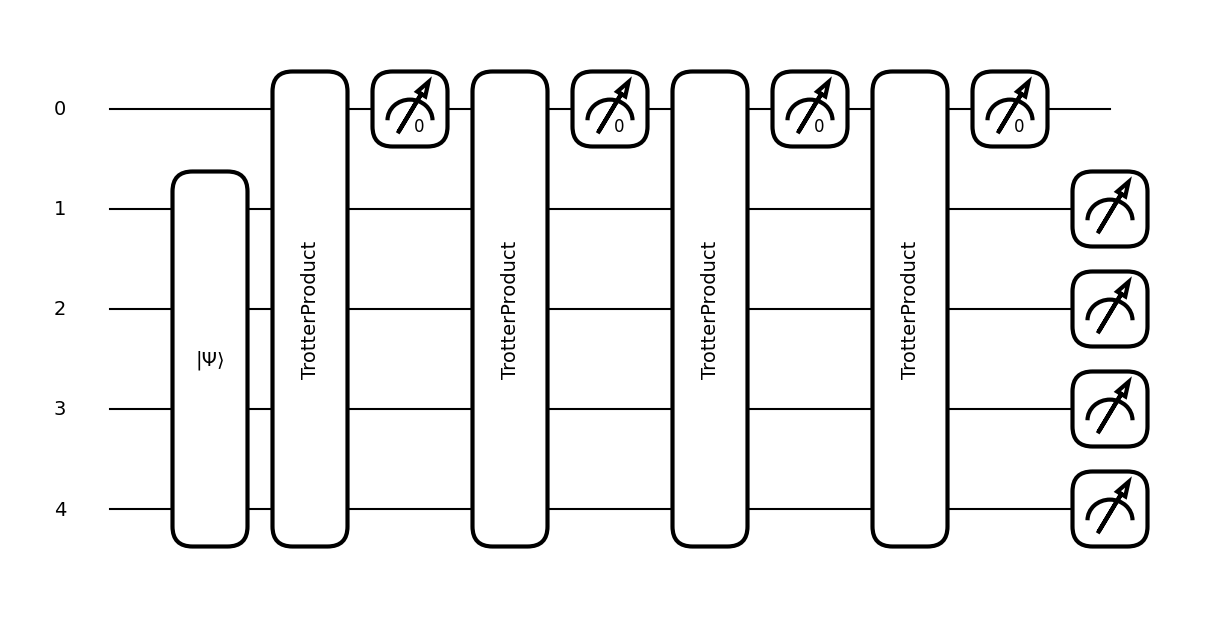

In [6]:
# ---------------------------------------------------------
# Device (noiseless)
# ---------------------------------------------------------
def select_dev(error_rate, nqubits):
    # If need noise, we can add qml.DepolarizingChannel etc.
    if error_rate == 0:
        return qml.device("default.qubit", wires=nqubits + 1)
    else:
        # simple noise model
        return qml.device("default.mixed", wires=nqubits + 1)

def get_hamiltonian_for_ps_expval(nq, J):
    coeffs = []
    ops = []
    # system wires = 1 .. nq
    # so the internal index i corresponds to wire (i+1)

    for i in range(nq - 1):
        coeffs.append(J)
        ops.append(qml.PauliZ(i+1) @ qml.PauliZ(i+2))

    # periodic boundary term: Z_{nq} Z_1
    coeffs.append(J)
    ops.append(qml.PauliZ(nq) @ qml.PauliZ(1))

    # transverse X fields
    for i in range(nq):
        coeffs.append(J)
        ops.append(qml.PauliX(i+1))

    return qml.Hamiltonian(coeffs, ops)

# ---------------------------------------------------------
# Cosine filtering loop
# ---------------------------------------------------------


nqubits = 4
state = 1/np.sqrt(2**4) * np.ones(2**4)
H = get_hamiltonian_pl(4,1)
H_array = qml.matrix(H)
eval, _ = np.linalg.eigh(H_array)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_array))
H_op = load_pauli_op(H)
H_cos = load_pauli_op(SparsePauliOp(H^["Y"]))
time = np.pi/2
nqubits = 4
#error_rate = 1e-1
step = 4
threshold = 1e-4
err = 0
dev = qml.device('default.qubit')
@qml.qnode(dev)
def cosine_filtering_post_selction(H, H_cos, time, nqubits, error_rate,
                        step, threshold):
    state = np.zeros(2**nqubits)
    state[0] = 1
    qml.StatePrep(state, wires=range(1, nqubits+1))
    for i in range(step):
        qml.TrotterProduct(H_cos, -time, n=10, order=2)
        #qml.X(0)
        qml.measure(0, postselect=0)

    #return qml.expval(get_hamiltonian_for_ps_expval(4,1))
    #return qml.state()
    return qml.density_matrix(wires=range(1, nqubits+1))


qml.draw_mpl(cosine_filtering_post_selction)(H_op, H_cos, time, nqubits, err, step, threshold)
# result_ps = cosine_filtering_post_selction(H_op, H_cos, time, nqubits, err, step, threshold)
# exp = np.einsum("ij,ji->", result_ps, H_array)
# print('expectation is ', exp)

In [7]:
result_ps = cosine_filtering_post_selction(H_op, H_cos, time, nqubits, err, step, threshold)

In [8]:
exp = np.einsum("ij,ji->", result_ps, H_array)
print('expectation is ', exp)

expectation is  (0.28337696359829145+0j)


In [10]:
@qml.qnode(dev)
def cosine_filtering_ps_expectation_series_circuit(H, H_cos, time, nqubits, error_rate,
                                           step, threshold):
    """
    Return a list of expectation values for step = 1..max_step.
    """
    dev = qml.device("default.qubit", wires=nqubits+1)


    # prepare system state = |000...0>
    state = np.zeros(2**nqubits)
    state[0] = 1
    qml.StatePrep(state, wires=range(1, nqubits+1))

    # apply cosine filtering steps
    for _ in range(step):
        qml.TrotterProduct(H_cos, -time, n=10, order=2)
        qml.measure(0, postselect=0)

    # return system density matrix
    return qml.density_matrix(wires=range(1, nqubits+1))

# rho = cosine_filtering_ps_expectation_series_circuit(H, H_cos, time, nqubits, err,
#                                            step, threshold)
# exp_s = np.einsum("ij,ji->", rho, H_array)

    # ---- iterate steps ----

def cosine_filtering_ps_expectation_series1(H, H_cos, time, nqubits, error_rate,
                                           max_step, threshold):
    exp = []
    for i in range(max_step+1):
        rho = cosine_filtering_ps_expectation_series_circuit(H, H_cos, time, nqubits, error_rate,
                                           i, threshold)
        exp_s = np.einsum("ij,ji->", rho, H_array)
        exp.append(exp_s)
    return exp

#
exp_series = cosine_filtering_ps_expectation_series1(
    H_op, H_cos, time, nqubits, err, max_step=10, threshold=1e-4
)

print('expectation is ', exp_series)


expectation is  [np.complex128(0.88268343236509+0j), np.complex128(0.4787440337929061+0j), np.complex128(0.3816281250946257+0j), np.complex128(0.32513475003578+0j), np.complex128(0.28337696359829145+0j), np.complex128(0.24508298619181362+0j), np.complex128(0.20759639951239156+0j), np.complex128(0.17179772530064036+0j), np.complex128(0.1392767849366479+0j), np.complex128(0.11115534372029216+0j), np.complex128(0.08779847579989405+0j)]


## use mid-circuit measurement for noise case

In [206]:
def cosine_filtering_pl(H, H_cos, time, nqubits, error_rate,
                        steps, threshold):

    dev = select_dev(error_rate, nqubits)

    # ---------------------------------------------------------
    # 一步演化 + 后测量，用 postselection 得到新的 system density matrix
    # ---------------------------------------------------------
    @qml.qnode(dev, interface="numpy")
    def single_step(rho_sys):
        """输入 system density matrix，返回经过 filtering 后的新 system density matrix"""

        # 1. 构造 ancilla|0〉 ⊗ ρ_sys
        qml.StatePrep(rho_sys, wires=range(1, nqubits+1))  # system
        # ancilla 自动是 |0〉，无需准备

        # 2. 时间演化
        qml.TrotterProduct(H_cos, -time, n=10, order=2)

        # 3. 噪声
        if error_rate > 0:
            for w in range(nqubits + 1):
                qml.DepolarizingChannel(error_rate, wires=w)

        # 4. 后选择 ancilla = 0
        m = qml.measure(0, postselect=0)

        # 5. 只返回系统的 reduced density matrix
        return qml.density_matrix(wires=range(1, nqubits+1))
        #return qml.state()

    # ---------------------------------------------------------
    # 能量评估 QNode（只看系统部分）
    # ---------------------------------------------------------
    @qml.qnode(dev, interface="numpy")
    def energy_eval(rho_sys):
        qml.QubitDensityMatrix(rho_sys, wires=range(nqubits))
        return qml.expval(H)

    # ---------------------------------------------------------
    # 初始系统态 ρ_sys = |0...0⟩⟨0...0|
    # ---------------------------------------------------------
    psi = np.zeros(2**nqubits)
    psi[0] = 1
    rho = np.outer(psi, psi.conj())

    expectation_list = []
    probability_list = [1.0]   # step 0 prob = 1

    # ---------- Step #0 ----------
    E0 = energy_eval(rho)
    expectation_list.append(E0)

    # ---------- Filtering loop ----------
    for i in range(1, steps+1):

        # 一步 filtering
        rho_new = single_step(rho)

        # 成功概率 = ρ_new 的 trace（default.mixed 已经帮你归一化）
        prob = np.trace(rho_new).real
        probability_list.append(probability_list[-1] * prob)

        # 归一化 system ρ
        rho_new = rho_new / np.trace(rho_new)

        # 计算能量
        Ei = energy_eval(rho_new)
        expectation_list.append(Ei)

        # threshold 停止
        if Ei <= threshold:
            break

        # 进入下一轮
        rho = rho_new

    return np.array(expectation_list), np.array(probability_list)


def run_for_noise_levels(noise_list, H_op, H_cos, time, nqubits, steps, threshold):
    results = {}

    for err in noise_list:
        print(f"Running error_rate = {err} ...")
        exp_list, prob_list = cosine_filtering_pl(
            H_op, H_cos, time, nqubits, err, steps, threshold
        )
        results[err] = (exp_list, prob_list)

    return results

noise_list = [1e-2]
temp_result = run_for_noise_levels(noise_list, H_op, H_cos, time, nqubits, step, threshold)


Running error_rate = 0.01 ...


ValueError: Postselection is not allowed on the device with deferred measurements. The device must support the Projector gate to apply postselection.

## mid-circuit measurement and AA

R | Fidelity | Success Prob
--------------------------------
 0 |  0.06326 |     0.0928
 1 |  0.06326 |     0.6414
 2 |  0.06326 |     0.9995
 3 |  0.06326 |     0.6847
 4 |  0.06326 |     0.1211
 5 |  0.06326 |     0.0680
 6 |  0.06326 |     0.5969
 7 |  0.06326 |     0.9953
 8 |  0.06326 |     0.7264
 9 |  0.06326 |     0.1525
10 |  0.06326 |     0.0467


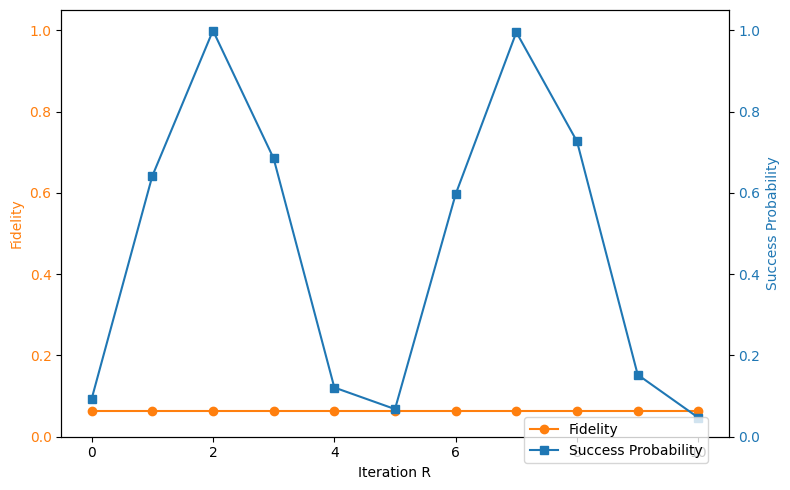

In [14]:
error_rate = 0
nqubits = 4
state = np.zeros(2**nqubits)
state[0] = 1
time = np.pi/2
dev = select_dev(error_rate, nqubits)
@qml.prod
def cosine_step(nqubits, H_cos, time):
    # for i in range(1, 1+nqubits):
    #     qml.Hadamard(wires=i)
    #qml.StatePrep(state, wires=range(1, nqubits + 1))
    qml.TrotterProduct(H_cos, -time, n=10, order=2)
    #return qml.state()


@qml.prod
def Oracle_op(anc_wires):
    """蓝色块：A → FlipSign(anc=0) → A†"""
    #LCUPrepare_op(weights, U_ops, anc_wires, sys_wires)
    qml.FlipSign(n=0, wires=anc_wires)
    #qml.adjoint(LCUPrepare_op)(weights, U_ops, anc_wires, sys_wires)


# =====================================================
# 4. 主过程：Amplitude Amplification
# =====================================================
def run_cosine_AA(nqubits=4, R=1):
    """运行一次 amplitude amplification for LCU"""
    #state = 1 / np.sqrt(2 ** 4) * np.ones(2 ** 4)
    H = get_hamiltonian_pl(4, 1)
    H_array = qml.matrix(H)
    vals, vecs = np.linalg.eigh(H_array)
    gs = vecs[:, np.argmin(vals)]
    emin = vals[0]
    emax = vals[-1]
    H_array = (H_array - emin * np.eye(2 ** nqubits)) / (emax - emin)
    H = SparsePauliOp.from_operator(Operator(H_array))
    H_cos = load_pauli_op(H^SparsePauliOp(["Y"]))


    n = 4
    n_anc = 1
    anc = list(range(n_anc))
    sys = list(range(n_anc, n_anc+n))
    all_wires = anc + sys
    #dev = qml.device("default.qubit", wires=len(all_wires)+1, shots=None)
    #dev = select_dev(error_rate, nqubits)
    dev = qml.device("default.qubit")
    @qml.qnode(dev)
    def circuit(iters):
        cosine_step(nqubits, H_cos, time)
        qml.AmplitudeAmplification(
            U = cosine_step(nqubits, H_cos, time),
            #U = prepare_init(n),
            O = Oracle_op(anc),
            iters = iters,
            fixed_point=False,
        )
        return qml.state()

    psi = circuit(R)
    #print('state vector is', psi)
    psi = psi.reshape((2 ** n_anc, 2 ** n))
    sys_amp = psi[0, :]
    # print('System state', sys_amp)
    success_prob = np.real(np.vdot(sys_amp, sys_amp))
    # success_prob = np.linalg.norm(sys_amp)
    normed = sys_amp / np.linalg.norm(sys_amp) if np.linalg.norm(sys_amp) > 0 else sys_amp
    fid = np.abs(np.vdot(normed, gs)) ** 2
    return fid, success_prob

R_list = list(range(11))
fidelities = []
success_probs = []

print("R | Fidelity | Success Prob")
print("-"*32)

for R in R_list:
    fid, p = run_cosine_AA(nqubits, R=R)
    #fid, p = run_AA_LCU(nqubits, m=6, R=R)
    fidelities.append(fid)
    success_probs.append(p)
    print(f"{R:>2d} | {fid:8.5f} | {p:10.4f}")

    # === 绘图 ===
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(R_list, fidelities, marker='o', label="Fidelity", color='tab:orange')
ax1.set_xlabel("Iteration R")
ax1.set_ylabel("Fidelity", color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_ylim(0, 1.05)

    # 第二个坐标轴绘制成功概率
ax2 = ax1.twinx()
ax2.plot(R_list, success_probs, marker='s', label="Success Probability", color='tab:blue')
ax2.set_ylabel("Success Probability", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylim(0, 1.05)

    # 图例
fig.legend(loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.tight_layout()
#plt.title("Amplitude Amplification Performance vs Iteration")
plt.show()

In [20]:
'''
We use Mid-circuit measurement in QRTE circuit for prepare states for AA
'''

error_rate = 0
nqubits = 4
state = np.zeros(2**nqubits)
state[0] = 1
time = np.pi/2
dev = select_dev(error_rate, nqubits)
@qml.prod
def cosine_step(nqubits, H_cos, time):
    # for i in range(1, 1+nqubits):
    #     qml.Hadamard(wires=i)
    #qml.StatePrep(state, wires=range(1, nqubits + 1))
    step = 2
    for _ in range(step):
        qml.TrotterProduct(H_cos, -time, n=10, order=2)
        qml.measure(0, postselect=0)
    #qml.TrotterProduct(H_cos, -time, n=10, order=2)
    #return qml.state()


@qml.prod
def Oracle_op(anc_wires):
    """蓝色块：A → FlipSign(anc=0) → A†"""
    #LCUPrepare_op(weights, U_ops, anc_wires, sys_wires)
    qml.FlipSign(n=0, wires=anc_wires)
    #qml.adjoint(LCUPrepare_op)(weights, U_ops, anc_wires, sys_wires)


# =====================================================
# 4. 主过程：Amplitude Amplification
# =====================================================
def run_cosine_AA(nqubits=4, R=1):
    """运行一次 amplitude amplification for LCU"""
    #state = 1 / np.sqrt(2 ** 4) * np.ones(2 ** 4)
    H = get_hamiltonian_pl(4, 1)
    H_array = qml.matrix(H)
    vals, vecs = np.linalg.eigh(H_array)
    gs = vecs[:, np.argmin(vals)]
    emin = vals[0]
    emax = vals[-1]
    H_array = (H_array - emin * np.eye(2 ** nqubits)) / (emax - emin)
    H = SparsePauliOp.from_operator(Operator(H_array))
    H_cos = load_pauli_op(H^SparsePauliOp(["Y"]))


    n = 4
    n_anc = 1
    anc = list(range(n_anc))
    sys = list(range(n_anc, n_anc+n))
    all_wires = anc + sys
    #dev = qml.device("default.qubit", wires=len(all_wires)+1, shots=None)
    #dev = select_dev(error_rate, nqubits)
    dev = qml.device("default.qubit")
    @qml.qnode(dev)
    def circuit(iters):
        cosine_step(nqubits, H_cos, time)
        qml.AmplitudeAmplification(
            U = cosine_step(nqubits, H_cos, time),
            #U = prepare_init(n),
            O = Oracle_op(anc),
            iters = iters,
            fixed_point=False,
        )
        return qml.state()

    psi = circuit(R)
    #print('state vector is', psi)
    psi = psi.reshape((2 ** n_anc, 2 ** n))
    sys_amp = psi[0, :]
    # print('System state', sys_amp)
    success_prob = np.real(np.vdot(sys_amp, sys_amp))
    # success_prob = np.linalg.norm(sys_amp)
    normed = sys_amp / np.linalg.norm(sys_amp) if np.linalg.norm(sys_amp) > 0 else sys_amp
    fid = np.abs(np.vdot(normed, gs)) ** 2
    return fid, success_prob

R_list = list(range(11))
fidelities = []
success_probs = []

print("R | Fidelity | Success Prob")
print("-"*32)

for R in R_list:
    fid, p = run_cosine_AA(nqubits, R=R)
    #fid, p = run_AA_LCU(nqubits, m=6, R=R)
    fidelities.append(fid)
    success_probs.append(p)
    print(f"{R:>2d} | {fid:8.5f} | {p:10.4f}")

    # === 绘图 ===
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(R_list, fidelities, marker='o', label="Fidelity", color='tab:orange')
ax1.set_xlabel("Iteration R")
ax1.set_ylabel("Fidelity", color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_ylim(0, 1.05)

    # 第二个坐标轴绘制成功概率
ax2 = ax1.twinx()
ax2.plot(R_list, success_probs, marker='s', label="Success Probability", color='tab:blue')
ax2.set_ylabel("Success Probability", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylim(0, 1.05)

    # 图例
fig.legend(loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.tight_layout()
#plt.title("Amplitude Amplification Performance vs Iteration")
plt.show()

R | Fidelity | Success Prob
--------------------------------


ValueError: Composite operators of mid-circuit measurements are not supported.

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

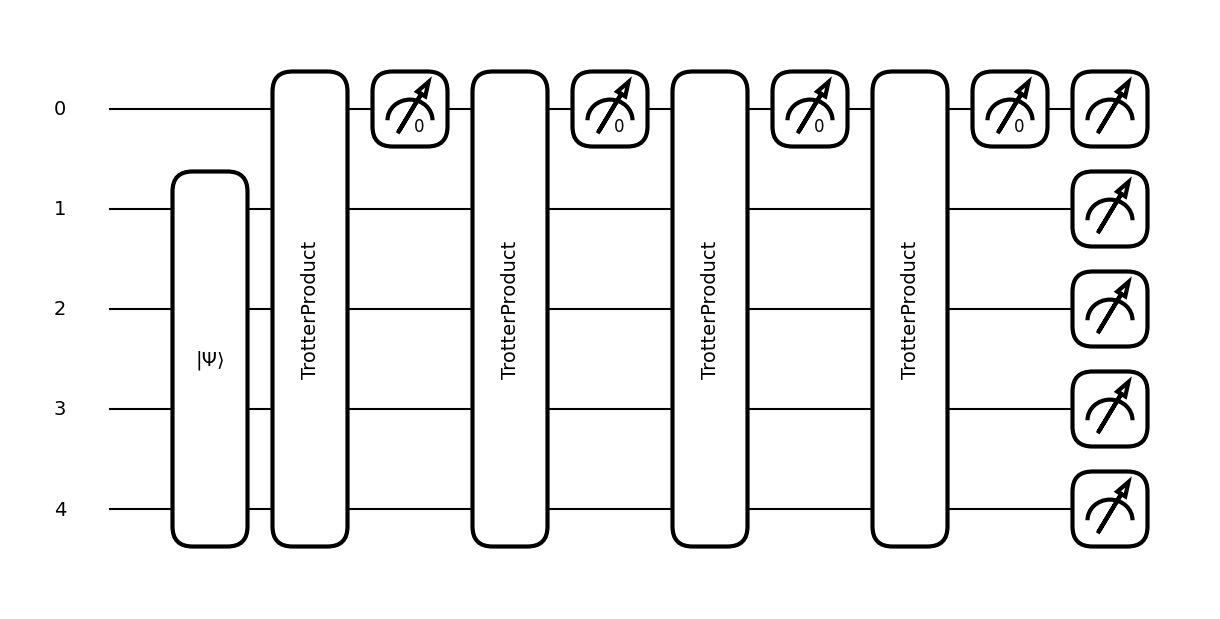

In [19]:
@qml.qnode(dev)
def cosine_filtering_post_selction(H, H_cos, time, nqubits, error_rate,
                        step, threshold):
    state = np.zeros(2**nqubits)
    state[0] = 1
    qml.StatePrep(state, wires=range(1, nqubits+1))
    for i in range(step):
        qml.TrotterProduct(H_cos, -time, n=10, order=2)
        #qml.X(0)
        qml.measure(0, postselect=0)

    #return qml.expval(get_hamiltonian_for_ps_expval(4,1))
    return qml.state()
    #return qml.density_matrix(wires=range(1, nqubits+1))


qml.draw_mpl(cosine_filtering_post_selction)(H_op, H_cos, time, nqubits, err, step, threshold)

In [26]:
@qml.prod
def cosine_step(nqubits, H_cos, time):
    step = 2
    for _ in range(step):
        qml.TrotterProduct(H_cos, -time, n=10, order=2)
        qml.measure(0, postselect=0)

qml.draw_mpl(cosine_step)(nqubits, H_cos, time)

ValueError: Composite operators of mid-circuit measurements are not supported.

# Compare Numerical and QC

In [193]:
def cosine_filtering_no_error(initial_state, scaled_hamiltonian, dt, nreps):
    Y = np.array([[0, -1j], [1j, 0]])
    U = sc.linalg.expm(-1j * np.kron(Y, scaled_hamiltonian) * dt)

    nstates = initial_state.shape[0]
    nq = int(np.log2(nstates))
    result = []

    rho = initial_state
    exp0 = np.einsum("ij,ji->", rho, scaled_hamiltonian)
    #print(f"Step #0: {exp0}")
    result.append(exp0)
    for i in range(1, nreps+1):
        rho_1 = np.pad(rho, (0, nstates))
        Urho_1 = U @ rho_1 @ U.conj().T
        new_rho = postselect_rho(Urho_1, nq, 0)
        new_rho /= np.trace(new_rho)

        exp = np.einsum("ij,ji->", new_rho, scaled_hamiltonian)
        rho = new_rho
        #print(f"Step #{i}: {exp}")
        result.append(exp)
    return result

def cosine_filtering_error(initial_state, scaled_hamiltonian, dt, nreps):
    Y = np.array([[0, -1j], [1j, 0]])
    U = sc.linalg.expm(-1j * np.kron(Y, scaled_hamiltonian) * dt)

    nstates = initial_state.shape[0]
    nq = int(np.log2(nstates))
    result = []

    rho = initial_state
    exp0 = np.einsum("ij,ji->", rho, scaled_hamiltonian)
    result.append(exp0)
    for i in range(1, nreps+1):
        rho_1 = np.pad(rho, (0, nstates))
        Urho_1 = U @ rho_1 @ U.conj().T
        new_rho = postselect_rho(Urho_1, nq, 0)
        new_rho /= np.trace(new_rho)
        ## add depolarizing error
        error_rate = 1e-2
        new_rho = (1-error_rate)* new_rho + error_rate * np.trace(new_rho)* np.eye(2**nqubits) / 2**nqubits
        exp = np.einsum("ij,ji->", new_rho, scaled_hamiltonian)
        rho = new_rho
        #print(f"Step #{i}: {exp}")
        result.append(exp)
    return result

#temp_init = np.ones(2**4)/ np.sqrt(2**4)
temp_init = np.zeros(2**4)
temp_init[0] = 1
initial_state = np.outer(temp_init, temp_init)
initial_state /= np.trace(initial_state)

cosine_no_error = cosine_filtering_no_error(initial_state, H_array, np.pi/2, 10)
cosine_error = cosine_filtering_error(initial_state, H_array, np.pi/2, 10)
noise_levels = [0, 1e-2]#, 1e-3, 1e-2, 1e-1]

results = run_for_noise_levels(
    noise_levels,
    H_op, H_cos,
    time=np.pi/2,
    nqubits=4,
    steps=10,
    threshold=1e-4
)
cosine_qc_no_error = results[0][0]
cosine_qc_error = results[0.01][0]


Step #0: (0.88268343236509+0j)
Running error_rate = 0 ...
Running error_rate = 0.01 ...


In [194]:
len(cosine_no_error)

11

In [195]:
len(cosine_error)

11

In [196]:
cosine_qc_error

array([0.88268343, 0.50437622, 0.38058714, 0.32007719, 0.27559892,
       0.23640647, 0.20030733, 0.16798589, 0.14034133, 0.11765827,
       0.09961607])

In [197]:
cosine_qc_no_error

array([0.88268343, 0.47874403, 0.38162813, 0.32513475, 0.28337696,
       0.24508299, 0.2075964 , 0.17179773, 0.13927678, 0.11115534,
       0.08779848])

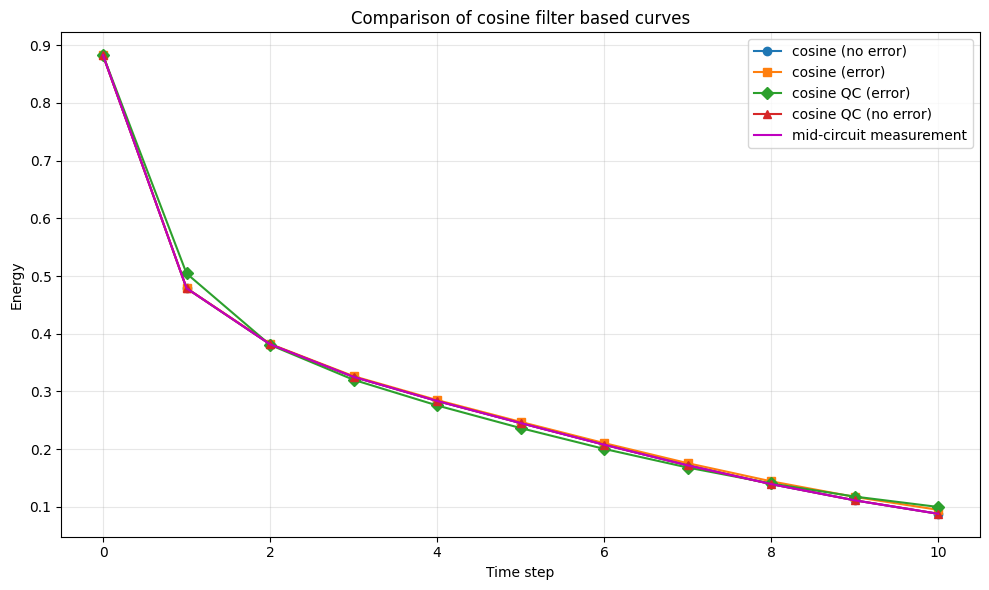

In [202]:
x = np.arange(len(cosine_no_error))

plt.figure(figsize=(10,6))

plt.plot(x, cosine_no_error, 'o-', label="cosine (no error)")
plt.plot(x, cosine_error, 's-', label="cosine (error)")
plt.plot(x, cosine_qc_error, 'D-', label="cosine QC (error)")
plt.plot(x, cosine_qc_no_error, '^-', label="cosine QC (no error)")
plt.plot(x, exp_series, 'm-', label="mid-circuit measurement")
plt.xlabel("Time step")
plt.ylabel("Energy")
plt.title("Comparison of cosine filter based curves")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()